In [5]:
import torch
from torcheval.metrics.functional import peak_signal_noise_ratio
input = torch.tensor([[0.1, 0.2], [0.3, 0.4]])
target = input * 0.9
peak_signal_noise_ratio(input, target)

tensor(19.8767)

In [5]:
from torch.utils.data import DataLoader
import torch
import random
from typing import Dict

# Import missing modules for optimization
import torch.optim as optim
from torch.optim import lr_scheduler

# Import our custom dataset and augmentation pipeline.
from process_sml import (
    AudioDatasetFolder, Compose,
    RandomPitchShift_wav,RandomVolume_wav,RandomAbsoluteNoise_wav,RandomSpeed_wav,RandomFade_wav,RandomFrequencyMasking_spec,RandomTimeMasking_spec,RandomTimeStretch_spec,
    compute_waveform_griffinlim,reconstruct_waveform)
# Import the UNet model and the training function from the training module.
from train_sml import UNet, train_model_source_separation,LiteResUNet
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the component map for the dataset.
COMPONENT_MAP = ["mixture", "drums", "bass", "other_accompaniment", "vocals"]
label_names = ["drums", "bass", "other_accompaniment", "vocals"]


argS = Compose([

    #spec transformation 
    RandomTimeStretch_spec(),
    #this two working properly together
    RandomFrequencyMasking_spec(),
    RandomTimeMasking_spec(),

])
argW = Compose(
 [
    # RandomPitchShift_wav(),
    RandomVolume_wav(),
    # RandomSpeed_wav(),
    RandomAbsoluteNoise_wav(),
    RandomFade_wav(),
 ]   
)


# Set random seeds for reproducibility.
torch.manual_seed(42)
random.seed(42)

# Choose device early.
device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the dataset.
dataset_multi = AudioDatasetFolder(
    csv_file='output_stems/mini.csv',
    audio_dir='.',  # adjust as needed
    components=COMPONENT_MAP,
    sample_rate=16000,
    duration=10.0,
    spec_transform=argS,  # list of transforms
    wav_transform=argW,
    is_track_id=True,
    input_name= "mixture",
    input_transformation="4-SPEC",
    rest_transformation="WAV"
)

loader_multi = DataLoader(dataset_multi, batch_size=8, shuffle=False)
sample_multi = next(iter(loader_multi))


# Plot spectrogram for the 'mixture' component.
spec = sample_multi['mixture'][0]  # select first sample and first channel


In [6]:
spec1 = sample_multi['vocals'][0]  # select first sample and first channel


In [7]:
spec1.shape

torch.Size([2, 160000])

In [8]:
spec.shape

torch.Size([4, 129, 5001])

In [8]:
spec.shape

torch.Size([2, 129, 5001])

In [2]:
import torchaudio
melscale_transform = torchaudio.transforms.MelScale(sample_rate=16000, n_stft=2048 // 2 + 1)

In [ ]:
melscale_spectrogram = melscale_transform(spec)

In [13]:
spec[0][0][0]

tensor(0.0044)

In [14]:
melscale_spectrogram[0][0][0]

tensor(0.0077)

In [7]:
spec.shape

torch.Size([2, 1025, 313])

In [6]:
melscale_spectrogram.shape

torch.Size([2, 128, 313])

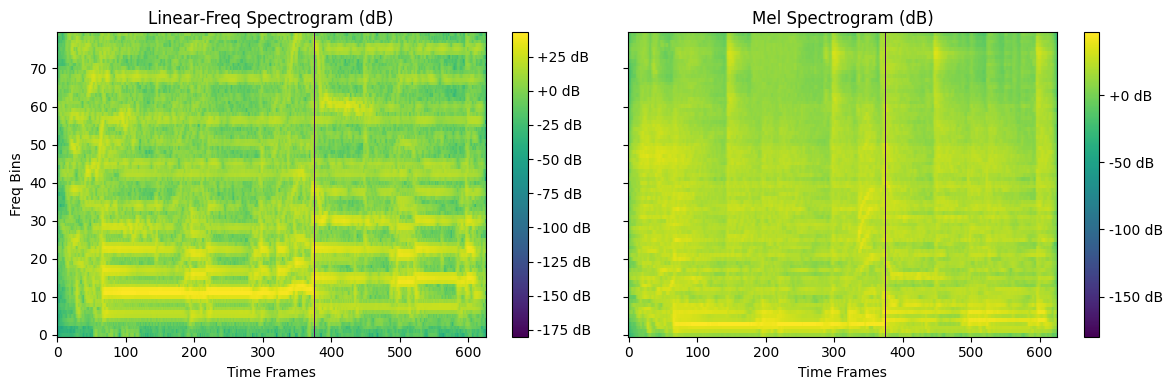

In [3]:
import matplotlib.pyplot as plt
import torch
import torchaudio

# Assume `spec` is your magnitude spectrogram for one example:
# shape: (freq_bins, time_steps)
# If you have a multi‐channel tensor, pick one channel:
# e.g. spec = sample_multi['mixture'][0,0]  # first batch, first channel

# Convert to decibels (optional but often clearer)
# sample_multi['mixture'] has shape (batch, channels, freq, time)
# pick batch 0, channel 0 → shape (freq, time)
spec = sample_multi['mixture'][0, 0]       

# If you’d rather average across both channels:
# spec = sample_multi['mixture'][0].mean(dim=0)

# Convert to decibels
spec_db = 20 * torch.log10(spec + 1e-9)

# Mel‐warped version (input must be (freq, time) or (..., freq, time))
n_fft = 2048
n_stft = n_fft // 2 + 1
melscale = torchaudio.transforms.MelScale(
    n_mels=80,
    sample_rate=16000,
    n_stft=n_stft
)
mel_spec = melscale(spec)            # → shape (80, time)
mel_spec_db = 20 * torch.log10(mel_spec + 1e-9)

# Now plot side by side
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

im1 = ax1.imshow(
    spec_db.cpu(), 
    aspect='auto', 
    origin='lower', 
    interpolation='none'
)
ax1.set_title("Linear‑Freq Spectrogram (dB)")
ax1.set_xlabel("Time Frames")
ax1.set_ylabel("Freq Bins")
fig.colorbar(im1, ax=ax1, format='%+2.0f dB')

im2 = ax2.imshow(
    mel_spec_db.cpu(), 
    aspect='auto', 
    origin='lower', 
    interpolation='none'
)
ax2.set_title("Mel Spectrogram (dB)")
ax2.set_xlabel("Time Frames")
# share y with ax1, so no new ylabel
fig.colorbar(im2, ax=ax2, format='%+2.0f dB')

plt.tight_layout()
plt.show()


In [2]:
spec.shape

torch.Size([2, 1025, 313])

In [5]:
spec = sample_multi['bass'][0]  # select first sample and first channel


In [6]:
spec.shape

torch.Size([2, 1025, 313])

In [2]:
wav_spec= compute_waveform_griffinlim(spec)

In [3]:
C = spec.size(0) // 2           # 4 // 2 == 2
mag   = spec[0:C,  :,  :]       # → [2, 1025, 157]
phase = spec[C: ,  :,  :]       # → [2, 1025, 157]
complex_spec = torch.polar(mag, phase)
reconstruction = reconstruct_waveform(complex_spec)


In [ ]:
drums_wav = sample_multi["drums"][0]

In [4]:
torch.is_complex(spec)

False

In [3]:
import torchaudio

# wav1 is shape [2, 64000], dtype=float
waveform = wav_spec.detach().cpu()     # now shape [2, 64000]
torchaudio.save("transformed.wav", waveform, sample_rate=16000)


In [ ]:
import torchaudio

# Ensure waveform is a FloatTensor in [-1,1]
waveform_tensor = spec.detach().cpu()

# Write out
torchaudio.save("reconstructed_pre.wav", waveform_tensor, 16000)

print("Wrote WAV to reconstructed.wav — now open it with your favorite audio player!")


In [ ]:

class ComputeSpectrogram:
    def __init__(self, n_fft: int = 2048, hop_length: int = 512, power: float = None, normalized: bool = False):
        """
        Compute the magnitude spectrogram using torchaudio.functional.spectrogram.
        
        Args:
            n_fft (int): The FFT window size.
            hop_length (int): The hop length for the window.
            power (float, optional): If None, returns a complex tensor and we take the magnitude.
                                      Otherwise, returns the power spectrogram.
            normalized (bool): If True, the spectrogram is normalized.
        """
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.power = power
        self.normalized = normalized

    def __call__(self, waveform: torch.Tensor) -> torch.Tensor:
        """
        Args:
            waveform (Tensor): Audio tensor. Expected shapes are (time), (channel, time) or (batch, channel, time).
        
        Returns:
            Tensor: The computed magnitude spectrogram with shape (channel, freq, time) (or with batch dimension if provided).
        """

        spec = compute_spectrogram(waveform,self.n_fft,self.hop_length,self.power,self.normalized)
        

        if self.power is None:
            return spec.abs()
        else:
            return spec
